In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import regions
from regions import Regions
from astropy.coordinates import search_around_sky
from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC
from scipy.spatial import KDTree
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm

In [2]:
cd .. 

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
from jwst_plots import make_cat_use
from jwst_plots import JWSTCatalog
import cutout_manager as cm
import extinction as ex
import moment_maker as mm

In [4]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [29]:
ext_map = ex.make_extinction_map(ext=CT06_MWLoc(), Av_fill=90)
ww = ex.get_wcs()
ex.get_mass_estimate(ext_map, ww)

<Quantity 20706.12412163 solMass>

In [30]:
ext_map = ex.make_extinction_map(ext=I05_MWAvg(), Av_fill=85)
ex.get_mass_estimate(ext_map, ww)

<Quantity 19630.39369322 solMass>

In [31]:
ext_map = ex.make_extinction_map(ext=CT06_MWGC(), Av_fill=90)
ex.get_mass_estimate(ext_map, ww)

<Quantity 20706.12412163 solMass>

In [25]:
ext_map = ex.make_extinction_map(ext=G21_MWAvg(), Av_fill=80)
ex.get_mass_estimate(ext_map, ww)


<Quantity 18430.24028683 solMass>

In [26]:
ext_map = ex.make_extinction_map(ext=RL85_MWGC(), Av_fill=75)
ex.get_mass_estimate(ext_map, ww)


<Quantity 17328.95035837 solMass>

In [27]:
ext_map = ex.make_extinction_map(ext=RRP89_MWGC(), Av_fill=85)
ex.get_mass_estimate(ext_map, ww)


<Quantity 19581.85258017 solMass>

In [28]:
ext_map = ex.make_extinction_map(ext=F11_MWGC(), Av_fill=65)
ex.get_mass_estimate(ext_map, ww)


<Quantity 15128.31716506 solMass>

# Plot Extinction Map

In [ ]:
ext_map = ex.make_extinction_map(ext=CT06_MWLoc(), Av_fill=90)

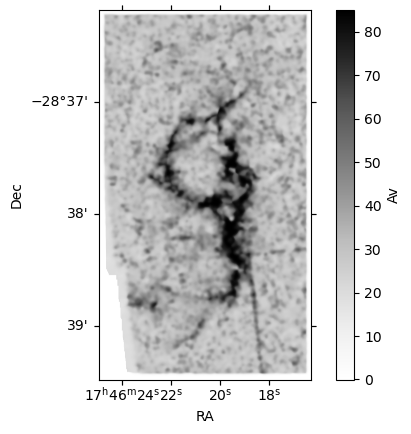

In [16]:
#ext_map[ext_map <= 18] = np.nan
#ww = ex.get_wcs()

ax = plt.subplot(projection=ww)
im = ax.imshow(ext_map, origin='lower', cmap='Greys')
plt.colorbar(im, label='Av', ax=ax)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

In [7]:
stellar_density_map = ex.make_stellar_density_map()
stellar_density_map[stellar_density_map == 0] = np.nan
stellar_density_map[stellar_density_map > 20] = np.nan

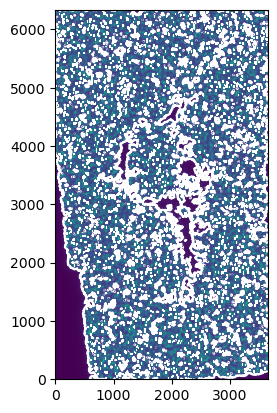

In [8]:
plt.imshow(stellar_density_map, origin='lower', vmin=0, vmax=20)
plt.contour(stellar_density_map, levels=[2.5], colors='white')

In [9]:
separation_map = ex.make_stellar_separation_map()

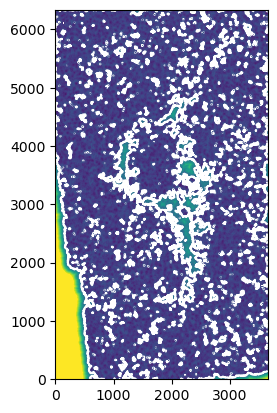

In [10]:
separation_map[separation_map == 0] = np.nan
separation_map[separation_map < 0.1] = np.nan
plt.imshow(separation_map, origin='lower', vmin=0, vmax=5)
plt.contour(stellar_density_map, levels=[2.5], colors='white')

(-0.1822653494996368, 4.0)

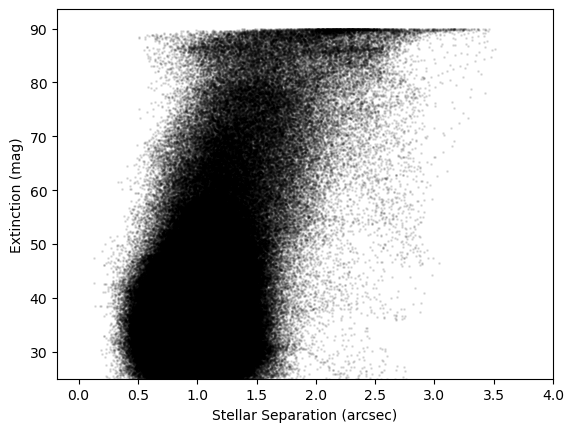

In [36]:
plt.scatter(separation_map[::5,::5].flatten(), ext_map[::5,::5].flatten(), s=1, alpha=0.1, color='k')
plt.xlabel('Stellar Separation (arcsec)')
plt.ylabel('Extinction (mag)')
plt.ylim(bottom=25)
plt.xlim(right=4)

In [37]:
bins_x = np.linspace(0, 4, 100)
bins_y = np.linspace(25, 100, 100)

h,_,__ = np.histogram2d(separation_map[~np.isnan(separation_map)], ext_map[~np.isnan(separation_map)], bins=(bins_x, bins_y))

Text(0, 0.5, 'Extinction (mag)')

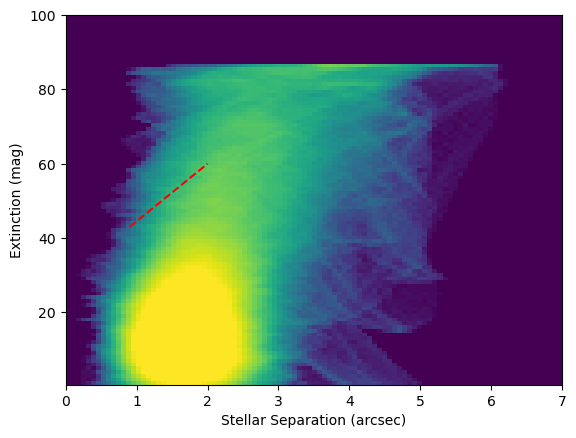

In [38]:
norm = simple_norm(h, 'log', percent=90)
plt.imshow(h.T, origin='lower', aspect='auto', extent=(0, 7, 0.5, 100), norm=norm)
plt.plot([0.9, 2], [43, 60], color='red', linestyle='--')
plt.xlabel('Stellar Separation (arcsec)')
plt.ylabel('Extinction (mag)')

## Outflows

In [8]:
def get_percentile_list(data, percents=[98, 99, 99.9, 99.99]):
    #[87, 95, 99, 99.5, 99.9, 99.99]
    arr = []
    for per in percents:
        arr.append(np.nanpercentile(data, per))
    return np.array(arr)

In [16]:
clump1 = SkyCoord('17:46:19.2287619119', '-28:38:29.2978617171', unit=(u.hourangle, u.deg))
clump2 = SkyCoord('17:46:19.5945777603', '-28:38:09.9402161687', unit=(u.hourangle, u.deg))

clump1_SiO_mom0_low = mm.get_ACES_mom0(clump1, 25*u.arcsec, 25*u.arcsec, 'SiO 2-1', -60*u.km/u.s, -55*u.km/u.s)
clump1_SiO_mom0_high = mm.get_ACES_mom0(clump1, 25*u.arcsec, 25*u.arcsec, 'SiO 2-1', -55*u.km/u.s, -50*u.km/u.s)

clump2_SiO_mom0_low = mm.get_ACES_mom0(clump2, 10*u.arcsec, 10*u.arcsec, 'SiO 2-1', -60*u.km/u.s, -55*u.km/u.s)
clump2_SiO_mom0_high = mm.get_ACES_mom0(clump2, 10*u.arcsec, 10*u.arcsec, 'SiO 2-1', -55*u.km/u.s, -50*u.km/u.s)

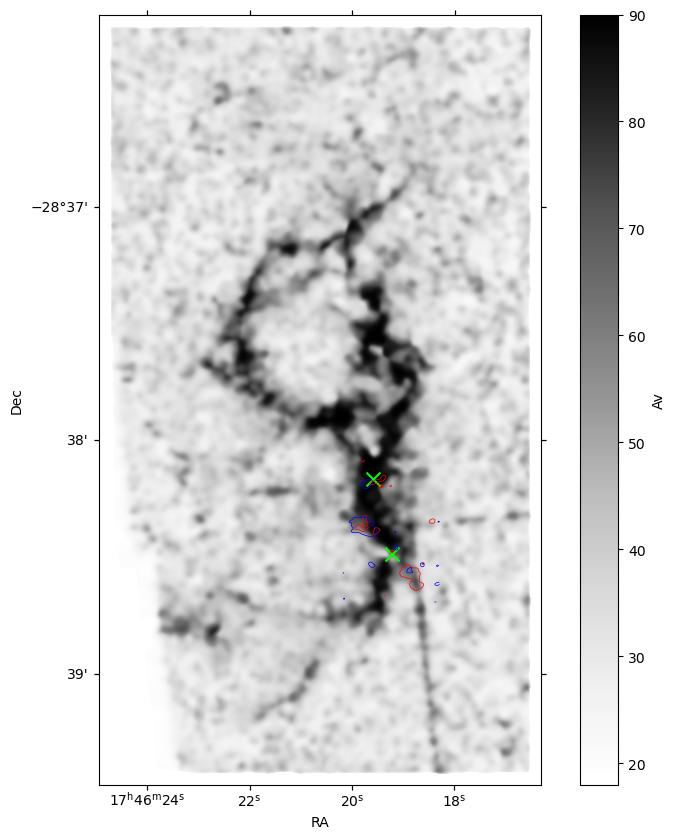

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=ww)

im = ax.imshow(ext_map, origin='lower', cmap='Greys')

ax.scatter(clump1.ra.deg, clump1.dec.deg, color='lime', transform=ax.get_transform('world'), marker='x', s=100)
ax.contour(clump1_SiO_mom0_low.data, levels=[np.percentile(clump1_SiO_mom0_low.data, 95)], colors='red', transform=ax.get_transform(clump1_SiO_mom0_low.wcs), linewidths=0.5)
ax.contour(clump1_SiO_mom0_high.data, levels=[np.percentile(clump1_SiO_mom0_high.data, 95)], colors='blue', transform=ax.get_transform(clump1_SiO_mom0_high.wcs), linewidths=0.5)

ax.scatter(clump2.ra.deg, clump2.dec.deg, color='lime', transform=ax.get_transform('world'), marker='x', s=100)
ax.contour(clump2_SiO_mom0_low.data, levels=[np.percentile(clump2_SiO_mom0_low.data, 95)], colors='red', transform=ax.get_transform(clump2_SiO_mom0_low.wcs), linewidths=0.5)
ax.contour(clump2_SiO_mom0_high.data, levels=[np.percentile(clump2_SiO_mom0_high.data, 95)], colors='blue', transform=ax.get_transform(clump2_SiO_mom0_high.wcs), linewidths=0.5)

plt.colorbar(im, label='Av', ax=ax)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')